# Q1

Below the drawing of the bayesian network together with CPTs are provided.

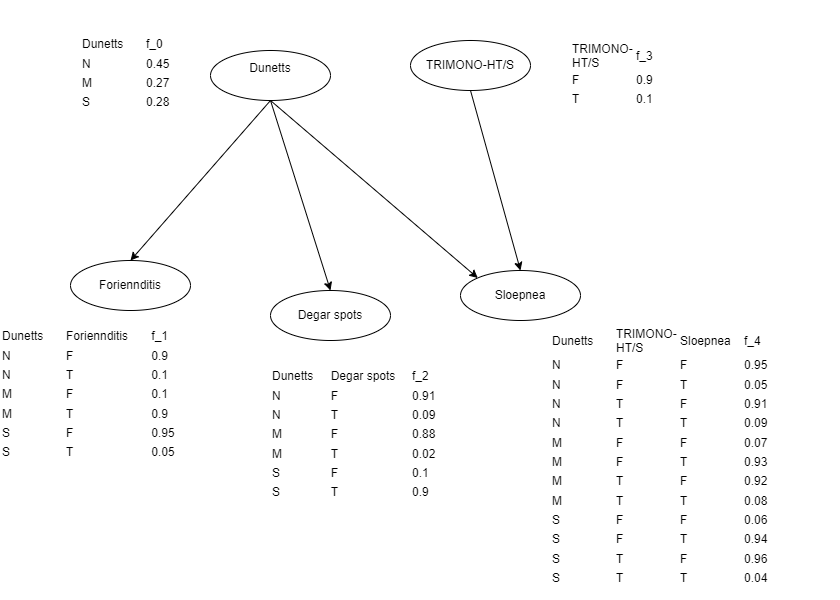

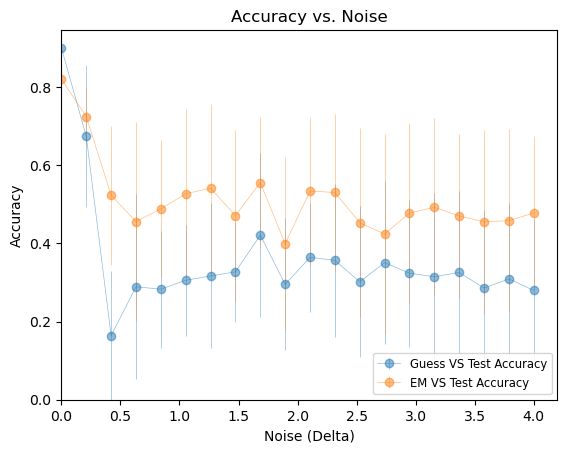

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def perturb_last_dim(arr, delta):
    def recursive_iteration(current_index, dimension_indices, delta):
        if current_index == len(arr.shape) - 1:
            # Reached the last dimension
            idxs  = [tuple(dimension_indices + [i]) for i in range(arr.shape[-1])]
            r_values = [np.random.uniform(0, delta) for i in range(arr.shape[-1])]
            for i in range(arr.shape[-1]):
                idx = tuple(dimension_indices + [i])
                arr[idx] = (arr[idx] + r_values[i]) / (1 + sum(r_values))
            return arr
        else:
            # Iterate over the current dimension
            for i in range(arr.shape[current_index]):
                perturbed_arr = recursive_iteration(current_index + 1, dimension_indices + [i], delta)
        return perturbed_arr

    # Start recursion with an empty list of indices
    perturbed_arr = recursive_iteration(0, [], delta)
    return perturbed_arr

def perturb_cpts(cpts, delta):
    perturbed_cpts = []
    delta1 = np.random.uniform(0, delta)
    delta2 = np.random.uniform(0, delta)
    for i in [0, 1, 2, 3, 4]:
        cpts[i] = perturb_last_dim(cpts[i], delta)
    return cpts

class EMLearner():
    def __init__(self):
        self.joint_pr = None
        self.post_pr = None
        self.cpts = None

    def get_cpts(self):
        return self.cpts

    def eval_prior_table(self, cpts):
        # The join probability of Sloepnea,Foriennditis,Degar spots, Trimono-ht/s and dunetts syndrom
        f = cpts
        joint_pr = np.zeros(shape=(2, 2, 2, 2, 3))
        post_pr = np.zeros(shape=(2, 2, 2, 2, 3))
        for dune in range(3):
            for sloe in range(2):
                for fori in range(2):
                    for dega in range(2):
                        for trim in range(2):
                            # Evaluate joint probability P(dune, sloe, fori, dega, trim)
                            pr = (
                                f[0][dune] * f[1][dune, fori] * f[2][dune, dega] * 
                                f[3][trim] * f[4][dune, trim, sloe]
                            ).item()

                            if (pr > 1) or np.isnan(pr):
                                raise Exception("Wrong pr: {pr}")
                            joint_pr[sloe, fori, dega, trim, dune] = pr
                            
        # Normalize to obtain posterior of the hidden variable: P(dune|sloe, fori, dega, trim)
        for sloe in range(2):
            for fori in range(2):
                for dega in range(2):
                    for trim in range(2):
                        post_pr_den = joint_pr[sloe, fori, dega, trim, :].sum()
                        post_pr[sloe, fori, dega, trim, :] = joint_pr[sloe, fori, dega, trim, :] / post_pr_den if (post_pr_den != 0) else 0

        if (abs(joint_pr.sum() - 1) > 0.1):
            raise Warning(f"Sum of joint probabilities in the probability table is {joint_pr.sum()}, but it's expected to be equal to 1")             
        return (joint_pr, post_pr)

    def expectation(self, data):
        missing_count = (data[:, 4] == -1).sum()
        given_count = len(data) - missing_count
        new_data_count = missing_count * 3 + given_count
        idx = 0
        weighted_data = np.zeros(shape=(new_data_count, 7), dtype=np.float64)
        for example in data:
            weighted_example = np.zeros(shape=7, dtype=np.float64)

            # Estimate Dunetts if it's missing
            if example[4] == -1:
                for dune in range(3):
                    weighted_example[:3] = example[:3]
                    weighted_example[4] = dune
                    sloe, fori, dega, trim = example[0:4]
                    weighted_example[5] = self.joint_pr[int(sloe), int(fori), int(dega), int(trim), int(dune)]
                    if np.isnan(self.post_pr[int(sloe), int(fori), int(dega), int(trim), int(dune)]):
                        raise Exception("nan value")
                    weighted_example[6] = self.post_pr[int(sloe), int(fori), int(dega), int(trim), int(dune)]
                    weighted_data[idx, :] = weighted_example[:]
                    idx += 1
            else:
                weighted_example[:5] = example
                weighted_example[5:] = 1
                weighted_data[idx, :] = weighted_example
                idx += 1
        
        sum_joint_pr = weighted_data[:, 5].sum()
            
        return (weighted_data, sum_joint_pr)
    
    def maximization(self, weighted_data):
        cpts = []

        # condition structure [sloe, fori, dega, trim, dune]
        factor_conditions = [
            [{4: [0, 1, 2]}, {}], # cpt_0
            [{1: [0, 1]}, {4: [0, 1, 2]}], # cpt_1
            [{2: [0, 1]}, {4: [0, 1, 2]}], # cpt_2
            [{3: [0, 1]}, {}], # cpt_3
            [{0: [0, 1]}, {4: [0, 1, 2], 3: [0, 1]}] # cpt_4
        ]

        for factor_condition in factor_conditions:
            cpt = pseudo_pr(weighted_data, *factor_condition)
            cpts.append(cpt)

        return cpts

    def fit(self, train_data: np.array, cpts, criteria=0.01, delta=1):
        data = train_data
        for iter in range(2000):
            self.joint_pr, self.post_pr = self.eval_prior_table(cpts)
            weighted_data, new_sum_joint_pr = self.expectation(data)
            cpts = self.maximization(weighted_data)
            if iter > 0:
                error_rate = abs(new_sum_joint_pr - prev_sum_joint_pr) / prev_sum_joint_pr
                # print(f"Error rate: {100*error_rate:.2f}%")
                if error_rate < criteria:
                    # print("EM solution converged successfully!")
                    break
            prev_sum_joint_pr = new_sum_joint_pr
        # if error_rate >= criteria:
            # print("The solution didn't converge!")
        self.cpts = cpts

    def predict(self, example: np.array, cpts):
        _, self.post_pr = self.eval_prior_table(cpts)
        example_to_int = list(example.astype(int))
        return np.argmax(self.post_pr[*example_to_int, :])

    def eval_accuracy(self, test_data, cpts):
        success = 0
        for test_data_point in test_data:
             test_features = test_data_point[:4]
             test_value = test_data_point[4]
             est_value = self.predict(test_features, cpts)
             if est_value == test_value:
                 success += 1
        return success/test_data.shape[0]



def read_data(file_name):
    data = np.genfromtxt(file_name)
    return data

def modify_data_type(data):
    # Example manipulation
    modified_data = data.copy()  # Copy to avoid modifying the original array

    # Perform your manipulations here...
    # Ensure that these manipulations do not change the type of the first 5 columns to non-integer

    # Cast the first 5 columns back to integers to ensure they remain integers
    modified_data[:, :5] = modified_data[:, :5].astype(np.int16)

    return modified_data

def pseudo_pr(data, num_condition: dict, den_condition: dict):
    # Initialize indices and shape for the numerator
    data = modify_data_type(data)
    num_index = next(iter(num_condition))
    num_values = num_condition[num_index]
    num_len = len(num_values)

    # Initialize variables for the denominator
    den_given = bool(den_condition)
    den_indices = list(den_condition.keys()) if den_given else []
    den_shape = [len(den_condition[den_index]) for den_index in den_indices] if den_given else []

    # Determine the shape of the CPT based on whether the denominator is given
    cpt_shape = [*den_shape, num_len] if den_given else [num_len]
    cpt = np.zeros(shape=cpt_shape)

    def recursive_counter(cpt, indices, shape, den_indices, filtered_data, num_condition, den_condition):
        if len(indices) == len(shape):
            # Compute the probability for the current indices
            num_index = next(iter(num_condition))
            num_value = num_condition[num_index][indices[-1]]
            num_data_filtered = filtered_data[(filtered_data[:, num_index] == num_value)]

            # Compute sums for the numerator and denominator
            num_weight_sum = num_data_filtered[:, 6].sum()
            den_weight_sum = filtered_data[:, 6].sum() if den_indices else data[:, 6].sum()
            
            # Update the CPT
            cpt[tuple(indices)] = num_weight_sum / den_weight_sum if den_weight_sum != 0 else 0
        else:
            # Prepare the filtered data for the next level of recursion
            next_filtered_data = filtered_data
            if den_indices and indices:
                den_index = den_indices[len(indices)-1]
                den_value = den_condition[den_index][indices[-1]]
                next_filtered_data = filtered_data[filtered_data[:, den_index].astype(int) == den_value]
            
            for index in range(shape[len(indices)]):
                recursive_counter(cpt, indices + [index], shape, den_indices, next_filtered_data, num_condition, den_condition)

        return cpt

    # Run the recursive counter to compute raw probabilities
    cpt = recursive_counter(cpt, [], cpt_shape, den_indices, data, num_condition, den_condition)

    # Normalize the last dimension of cpt so that it sums to 1
    sum_over_last_dim = np.sum(cpt, axis=-1, keepdims=True)
    cpt = np.divide(cpt, sum_over_last_dim, where=sum_over_last_dim!=0)

    return cpt

def main():
    # P(dune)
    # States: t->True, m->mild, s->severe, n-> not present
    cpt_0 = np.array([0.45, 0.27, 0.28])  # For dune = 'n', 'm', 's'. 

    # P(fori|dune) guessed piror
    cpt_1 = np.array([
        [0.9, 0.1],  # For dune='n'
        [0.1, 0.9],  # For dune='m'
        [0.95, 0.05]  # For dune='s'
    ])

    # P(dega|dune) guessed piror
    cpt_2 = np.array([
        [0.91, 0.09],  # For dune='n'
        [0.88, 0.02],  # For dune='m'
        [0.1, 0.9]  # For dune='s'
    ])

    # P(trim)
    cpt_3 = np.array([0.9, 0.1])

    # P(sloe|trim, dune) guessed piror
    cpt_4 = np.array([
        [[0.95, 0.05], [0.91, 0.09]],  # For dune='n'
        [[0.07, 0.93], [0.92, 0.08]],  # For dune='m'
        [[0.06, 0.94], [0.96, 0.04]]  # For dune='s'
    ])

    guess_cpts = [cpt_0, cpt_1, cpt_2, cpt_3, cpt_4]


    # Read train data
    train_data = read_data('./data/traindata.txt')
    test_data = read_data('./data/testdata.txt')

    em_learner = EMLearner()
    deltas = np.zeros(shape=20) 
    guess_accuracies = np.zeros(shape=(20, 20))
    em_test_accuracies = np.zeros(shape=(20, 20))
    for delta_idx, delta in enumerate(np.linspace(0, 4, num=20)):
        # print(f"Delta: {delta}")
        for trial in range(20):
            # print(f"Trial: {trial}")
            deltas[delta_idx] = delta
            perturbed_guess_cpts = perturb_cpts(guess_cpts, delta)
            em_learner.fit(train_data, perturbed_guess_cpts, criteria=0.01, delta=delta)
            em_cpts = em_learner.get_cpts()
            guess_accuracies[delta_idx, trial] = em_learner.eval_accuracy(test_data, perturbed_guess_cpts)
            em_test_accuracies[delta_idx, trial] = em_learner.eval_accuracy(test_data, em_cpts)

    _, ax = plt.subplots()
    ax.errorbar(deltas, guess_accuracies.mean(axis=1), yerr=guess_accuracies.std(axis=1), label='Guess VS Test Accuracy', alpha=0.5, fmt='-o', lw=0.5)
    ax.errorbar(deltas, em_test_accuracies.mean(axis=1), yerr=em_test_accuracies.std(axis=1), label='EM VS Test Accuracy', alpha=0.5, fmt='-o', lw=0.5)
    ax.set_title(f"Accuracy vs. Noise")
    ax.set_xlabel("Noise (Delta)")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='lower right', fontsize='small')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    plt.show()
    # for cpt in cpts:
    #     print(cpt)

if __name__ == '__main__':
    main()